In [1]:
from global_variables_final_for_git import Global_Vars
from prep_for_model_for_git import Model_preparation

class Tensorflow_model(object):
    def __init__(self, mp):
        pass
    
if __name__=="__main__":
    class Args(object):
        def __init__(self):
            self.gene = "MYOD1"
            self.distance = 150
            self.use_tad_info = True
            self.pcc_lowerlimit_to_filter_dhss = 0.2
            self.take_log2_tpm = True
            self.filter_tfs_by = "zscore" # or "pcc"
            self.lowerlimit_to_filter_tfs = 4.5 
            self.take_this_many_top_fts = 20  # all dhss/tfs will already be filtered by pcc(or zscore)
            self.init_wts_type = "corr"
            self.outputDir = "/Users/Dinesh/Dropbox/Github/predicting_gex_with_nn_git/Output"
            self.use_random_DHSs = False
            self.use_random_TFs = False
            self.max_iter = 300
            
    args = Args()
    gv = Global_Vars(args)
    mp = Model_preparation(gv)

2018-01-09 12:37:08,609: global_variables_final_for_git: INFO    : Setting up the DNase-seq dataframe and gene expression vector..
global_variables_final_for_git.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_roi_dhss["pcc"] = pccs
2018-01-09 12:37:18,007: global_variables_final_for_git: INFO    : Done. Setting up the training and testing split..
2018-01-09 12:37:18,008: prep_for_model_for_git: INFO    : Preparing the train/test dataf..


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
def init_nn_updates():
    nn_updates = {}
    nn_updates["train_loss"] = []  # loss == cost == rmse
    nn_updates["train_pcc"] = []
    nn_updates["test_loss"] = []
    nn_updates["test_pcc"] = []
    nn_updates["learning_rate"] = []
    return nn_updates

In [4]:
def get_performance_updates(sess, loss, pcc, train_data, test_data, nn_updates):
    '''Note: loss == rmse == cost (below)'''

    # success in train?
    l, p = sess.run([loss, pcc], feed_dict=train_data)
    nn_updates["train_loss"].append(l)
    nn_updates["train_pcc"].append(p)

    # success in test?
    l_, p_ = sess.run([loss, pcc], feed_dict=test_data)
    nn_updates["test_loss"].append(l_)
    nn_updates["test_pcc"].append(p_)

    return nn_updates

In [5]:
def train_tensorflow_nn(wts, trainX, trainY, testX, testY,
                        max_iter=500, pkeep_train=0.7, lamda=0.0001,
                        starter_learning_rate=0.5, decay_at_step=30,
                        use_sigmoid_h1=True, use_sigmoid_h2=True, use_sigmoid_yhat=False):
    '''Arugments:
    - All input arguments with "_" are real arrays to feed in as data.
    - lamda: regularization parameter
    - starter_learning_rate: Initial learning rate for the learning rate decay computation below
    - decay_at_step: learning rate is updated after this many training steps (Easier to think this way)
    '''
    # ------ Variables and placeholders ------
    nn_updates = init_nn_updates()
    X = tf.placeholder(tf.float32, shape=[None, wts[1].shape[0]], name="X")
    Y = tf.placeholder(tf.float32, [None, 1], name="Y")  # true Ys
    pkeep = tf.placeholder(tf.float32, name="pkeep")

    W1 = tf.Variable(tf.cast(wts[1], tf.float32), name="W1")
    b1 = tf.Variable(tf.zeros([wts[1].shape[1]]), name="H1_bn_offset")  # bn == batch normalization
    g1 = tf.Variable(tf.ones([wts[1].shape[1]]), name="H1_bn_scale")
    W2 = tf.Variable(tf.cast(wts[2], tf.float32), name="W2")
    W3 = None
    b2 = None
    g2 = None
    if not (wts[3] is None):
        W3 = tf.Variable(tf.cast(wts[3], tf.float32), name="W3")
        b2 = tf.Variable(tf.zeros([wts[2].shape[1]]), name="H2_bn_offset")
        g2 = tf.Variable(tf.zeros([wts[2].shape[1]]), name="H2_bn_scale")

    Yhat, loss = tf_model(X, Y, W1, W2, W3, b1, g1, b2, g2, pkeep, lamda)  # loss == rmse

    # ------ train parameters -----
    global_step = tf.Variable(0, trainable=False, name="global_step")  # this is like a counter when passed to minimize() function
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               decay_steps=decay_at_step, decay_rate=0.96, staircase=True)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # ------ performance metric (besides the loss or rmse) -----
    pcc = tf.contrib.metrics.streaming_pearson_correlation(Yhat, Y, name="pcc")

    # ------ start training ------
    with tf.Session() as sess:
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init)

        for i in range(max_iter):

            train_data = {X: trainX, Y: trainY, pkeep: pkeep_train}
            sess.run(train_step, feed_dict=train_data)
            nn_updates["learning_rate"].append(learning_rate.eval())  # to be used with Adam opt.

            if (i % 10 == 0):
                test_data = {X: testX, Y: testY, pkeep: 1}
                nn_updates = get_performance_updates(sess, loss, pcc, train_data, test_data, nn_updates)

        # Now predict the performance, and get the weights
        nn_updates["yhat_train"] = sess.run(Yhat, feed_dict={X: trainX, Y: trainY, pkeep: 1})  # model prediction on the training set
        nn_updates["yhat_test"] = sess.run(Yhat, feed_dict={X: testX, Y: testY, pkeep: 1})
        if (np.isnan(nn_updates["yhat_test"]).any()):
            print("print logger warning that yhat_test has a nan")
        nn_updates["W1"] = W1.eval()
        nn_updates["W2"] = W2.eval()
        if not (wts[3] is None):
            nn_updates["W3"] = W3.eval()

    return nn_updates

In [6]:
def tf_model(X, Y, W1, W2, W3, b1, g1, b2, g2, pkeep, lamda, 
             use_sigmoid_h1=True, use_sigmoid_h2=True, use_sigmoid_yhat=False):
    
    # -------- the core model ---------
    H1 = tf.matmul(X, W1, name="h1")
    H1_mean, H1_var = tf.nn.moments(H1, axes=[0], keep_dims=True, name="h1_moments")
    H1_bn = tf.nn.batch_normalization(H1, H1_mean, H1_var, offset=b1, scale=g1,
                                      variance_epsilon=0.000001, name="h1_bn")  # perform batch normalization
    if (use_sigmoid_h1):
        H1_bnt = tf.nn.sigmoid(H1_bn, name="h1_bn_sigmoid")
    else:
        H1_bnt = tf.nn.relu(H1_bn, name="h1_bn_relu")
    H1_bnd = tf.nn.dropout(H1_bnt, pkeep, name="h1_after_bn_transformation_and_dropout")
    
    if not (W3 is None):
        H2 = tf.matmul(H1_bnd, W2, name="h2")
        H2_mean, H2_var = tf.nn.moments(H2, axes=[0], keep_dims=True, name="h2_moments")
        H2_bn = tf.nn.batch_normalization(H2, H2_mean, H2_var, offset=b2, scale=g2,
                                          variance_epsilon=0.000001, name="h2_bn")
        if (use_sigmoid_h2):
            H2_bnt = tf.nn.sigmoid(H2_bn, name="h2_bn_sigmoid")
        else:
            H2_bnt = tf.nn.sigmoid(H2_bn, name="h2_bn_relu")
        H2_bnd = tf.nn.dropout(H2_bnt, pkeep, name="h2_after_bns_transformation_and_dropout")
        if (use_sigmoid_yhat):
            Yhat = tf.nn.sigmoid(tf.matmul(H2_bnd, W3), name="Yhat_sigmoid_W3_present")
        else:
            Yhat = tf.nn.sigmoid(tf.matmul(H2_bnd, W3), name="Yhat_relu_W3_present")
        regularizer = tf.add(tf.add(tf.nn.l2_loss(W1), tf.nn.l2_loss(W2)), tf.nn.l2_loss(W3), name="regularizer")
    else: # no W3, W2.shape[1]==1
        if (use_sigmoid_yhat):
            Yhat = tf.nn.sigmoid(tf.matmul(H1_bnd, W2), name="Yhat_sigmoid_noW3")
        else:
            Yhat = tf.nn.relu(tf.matmul(H1_bnd, W2), name="Yhat_relu_noW3")
        regularizer = tf.add(tf.nn.l2_loss(W1), tf.nn.l2_loss(W2), name="regularizer")

    loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(Yhat, Y)), name="loss")  # cost function to minimize
    loss = loss + lamda * regularizer
    # loss = tf.reduce_mean((Y - Yhat)**2) + tf.multiply(lamda, tf.add(tf.reduce_sum(tf.square(W1)), tf.reduce_sum(tf.square(W2))))  # this is not working (yields negative loss); default norm is euclidean

    return Yhat, loss

In [7]:
import numpy as np
# trainX = np.array(mp.train_dhss.transpose())
# testX = np.array(mp.test_dhss.transpose())

trainX = np.array(mp.train_joint.transpose())
testX = np.array(mp.test_joint.transpose())

trainY = np.array(mp.train_goi.tolist())
trainY = trainY.reshape(trainY.shape[0], -1)
testY = np.array(mp.test_goi.tolist())
testY = testY.reshape(testY.shape[0], -1)

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

((119, 18), (119, 1), (8, 18), (8, 1))


In [8]:
def get_random_wts(use_h2=False, i_frac=0.4, h1_frac=0.4):
    i = trainX.shape[1]
    h1 = int(i*i_frac)
    h2 = int(h1*h1_frac)
    o = 1

    wts = {}
    if (use_h2 == False):
        wts[1] = np.random.randn(i, h1)
        wts[2] = np.random.randn(h1,o)
        wts[3] = None
    else:
        wts[1] = np.random.randn(i, h1)
        wts[2] = np.random.randn(h1,h2)
        wts[3] = np.random.randn(h2,o)
    print(wts[1].shape, wts[2].shape)
    return wts

In [9]:
def get_percentage_error(nn_updates, testY):
    pes = [] # pes = percentage errors
    y_minus_yhat = abs(testY.flatten() - nn_updates["yhat_test"].flatten())
    for a,b in zip(y_minus_yhat, testY.flatten()):
        pes.append(a/b)
    return pes

In [31]:
def plot_scatter_performance(trainY, testY, nn_updates):
    plt.figure(figsize=(5,5))
    sns.regplot(trainY.flatten(), nn_updates["yhat_train"].flatten(), robust=False, fit_reg=False, scatter_kws={'alpha': 0.45}, color="salmon")
    sns.regplot(testY.flatten(), nn_updates["yhat_test"].flatten(), robust=False, fit_reg=False, color="steelblue")
    plt.xlim((0,1.1))
    plt.ylim((0,1.1))
    plt.plot([[0,0], [1,1]], "--")
    plt.xlabel("Real RPKM signal normalized")
    plt.ylabel("Predicted RPKM signal")
    plt.title("{}, Median per. error: {}".format(gv.gene_ofInterest, round(np.median(get_percentage_error(nn_updates, testY)),2)))

In [29]:
wts = get_random_wts(use_h2=True, i_frac=0.4, h1_frac=0.4)

((18, 7), (7, 2))


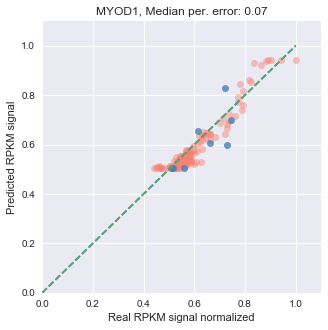

In [33]:
nn_updates = train_tensorflow_nn(wts,
                                 trainX, trainY, testX, testY,
                                 max_iter=200, pkeep_train=0.7, lamda=0.0000001,
                                 starter_learning_rate=0.7, decay_at_step=30,
                                 use_sigmoid_h1=True, 
                                 use_sigmoid_h2=False, 
                                 use_sigmoid_yhat=False)

plot_scatter_performance(trainY, testY, nn_updates)

In [13]:
'''hyperparams to train:
1. lambda
2. number of hidden layers
3. number of hidden units
3. starter learning rate
5. use_sigmoid_h1
6. use_sigmoid_h2'''

'hyperparams to train:\n1. lambda\n2. number of hidden layers\n3. number of hidden units\n3. starter learning rate\n5. use_sigmoid_h1\n6. use_sigmoid_h2'

In [14]:
mp.test_goi

E055_SKIN.PEN.FRSK.FIB.01_Epithelial    0.720689
E056_SKIN.PEN.FRSK.FIB.02_Epithelial    0.745050
E059_SKIN.PEN.FRSK.MEL.01_Epithelial    0.661716
E061_SKIN.PEN.FRSK.MEL.03_Epithelial    0.614801
E057_SKIN.PEN.FRSK.KER.02_Epithelial    0.558713
E058_SKIN.PEN.FRSK.KER.03_Epithelial    0.514834
E028_BRST.HMEC.35_Epithelial            0.727079
E027_BRST.MYO_Epithelial                0.512701
Name: (MYOD1, chr11:17740609-17741609, chr11:17240000-18100000), dtype: float64